In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import concatenate, Dense, Input, Flatten
from keras.optimizers import Adam

import sys
sys.path.append('../module/')

from util import moving_average
import gym2
from rl2.agents import eventDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
dt = 0.005
env = gym2.make("Pendulum-v1", dt)
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(3, activation="tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [4]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = eventDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [5]:
#safe learning
l = 0.5
step = 3000000
episode_step = int(200 * 0.05 / dt)
time_mode = False
a = agent((3,), env.observation_space.shape)
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
#a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
a.fit(env, lam=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step, loss_graph=0, time_mode=time_mode)







Training for 3000000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 71s 7ms/step - reward: -7.3851
5 episodes - episode_reward: -14770.125 [-17944.723, -6997.084] - loss: 622403.286 - mean_absolute_error: 32.433 - mean_q: -9.471

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 71s 7ms/step - reward: -7.2685
5 episodes - episode_reward: -14536.917 [-17291.535, -11207.070] - loss: 352545.156 - mean_absolute_error: 33.952 - mean_q: -13.034

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 60s 6ms/step - reward: -7.9948
5 episodes - episode_reward: -15989.520 [-17334.570, -14971.537] - loss: 174010.375 - mean_absolute_error: 28.720 - mean_q: -35.836

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 63s 6ms/step - reward: -8.1628
5 episodes - episode_reward: -16325.644 [-17215.919, -15858.672] - loss: 46847.816 - mean_absolute_error: 32.264 - mea

10000/10000 [==============================] - 59s 6ms/step - reward: -1.9688
5 episodes - episode_reward: -3937.643 [-11440.929, -152.025] - loss: 381077.906 - mean_absolute_error: 46.250 - mean_q: -306.244

Interval 30 (290000 steps performed)
10000/10000 [==============================] - 60s 6ms/step - reward: -6.0365
5 episodes - episode_reward: -12073.016 [-17575.809, -216.036] - loss: 1139465.875 - mean_absolute_error: 42.374 - mean_q: -307.966

Interval 31 (300000 steps performed)
10000/10000 [==============================] - 61s 6ms/step - reward: -5.8738
5 episodes - episode_reward: -11747.622 [-17376.693, -3722.312] - loss: 5408805.500 - mean_absolute_error: 146.461 - mean_q: -445.721

Interval 32 (310000 steps performed)
10000/10000 [==============================] - 60s 6ms/step - reward: -4.1377
5 episodes - episode_reward: -8275.416 [-12723.799, -170.390] - loss: 7414867.500 - mean_absolute_error: 173.737 - mean_q: -505.484

Interval 33 (320000 steps performed)
10000/10

10000/10000 [==============================] - 60s 6ms/step - reward: -5.8611
5 episodes - episode_reward: -11722.103 [-17434.039, -625.332] - loss: 1748.703 - mean_absolute_error: 10.105 - mean_q: -474.926

Interval 64 (630000 steps performed)
10000/10000 [==============================] - 60s 6ms/step - reward: -4.7253
5 episodes - episode_reward: -9450.602 [-15545.590, -165.940] - loss: 1460.025 - mean_absolute_error: 9.163 - mean_q: -507.115

Interval 65 (640000 steps performed)
10000/10000 [==============================] - 61s 6ms/step - reward: -1.7307
5 episodes - episode_reward: -3461.309 [-16588.909, -141.080] - loss: 1175.013 - mean_absolute_error: 9.289 - mean_q: -483.229

Interval 66 (650000 steps performed)
10000/10000 [==============================] - 63s 6ms/step - reward: -1.9495
5 episodes - episode_reward: -3899.014 [-17035.018, -185.166] - loss: 847.164 - mean_absolute_error: 8.688 - mean_q: -470.297

Interval 67 (660000 steps performed)
10000/10000 [==============

Interval 97 (960000 steps performed)
10000/10000 [==============================] - 60s 6ms/step - reward: -2.8369
5 episodes - episode_reward: -5673.808 [-15939.868, -184.435] - loss: 3121.444 - mean_absolute_error: 10.129 - mean_q: -376.434

Interval 98 (970000 steps performed)
10000/10000 [==============================] - 60s 6ms/step - reward: -0.0984
5 episodes - episode_reward: -196.763 [-246.332, -176.619] - loss: 3879.440 - mean_absolute_error: 9.014 - mean_q: -282.660

Interval 99 (980000 steps performed)
10000/10000 [==============================] - 60s 6ms/step - reward: -3.7954
5 episodes - episode_reward: -7590.728 [-16405.873, -199.636] - loss: 2061.970 - mean_absolute_error: 5.578 - mean_q: -264.364

Interval 100 (990000 steps performed)
10000/10000 [==============================] - 60s 6ms/step - reward: -0.0817
5 episodes - episode_reward: -163.374 [-170.039, -154.695] - loss: 278.649 - mean_absolute_error: 4.757 - mean_q: -227.970

Interval 101 (1000000 steps perfo

Interval 164 (1630000 steps performed)
10000/10000 [==============================] - 56s 6ms/step - reward: -4.1606
5 episodes - episode_reward: -8321.125 [-15996.303, -141.673] - loss: 3131.179 - mean_absolute_error: 4.364 - mean_q: -451.690

Interval 165 (1640000 steps performed)
10000/10000 [==============================] - 56s 6ms/step - reward: -6.0530
5 episodes - episode_reward: -12106.081 [-17102.386, -170.565] - loss: 1965.173 - mean_absolute_error: 9.013 - mean_q: -455.833

Interval 166 (1650000 steps performed)
10000/10000 [==============================] - 56s 6ms/step - reward: -5.1956
5 episodes - episode_reward: -10391.241 [-17686.027, -212.010] - loss: 326.804 - mean_absolute_error: 4.337 - mean_q: -508.450

Interval 167 (1660000 steps performed)
10000/10000 [==============================] - 56s 6ms/step - reward: -2.7487
5 episodes - episode_reward: -5497.497 [-16265.850, -160.678] - loss: 246.259 - mean_absolute_error: 3.704 - mean_q: -510.958

Interval 168 (167000

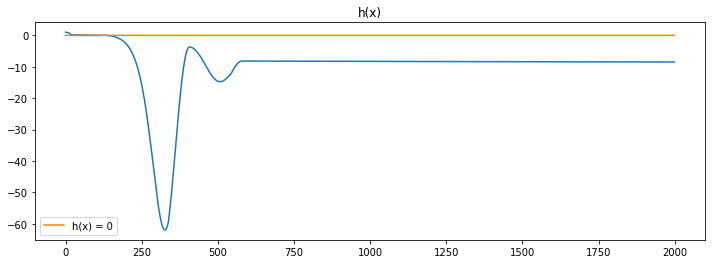

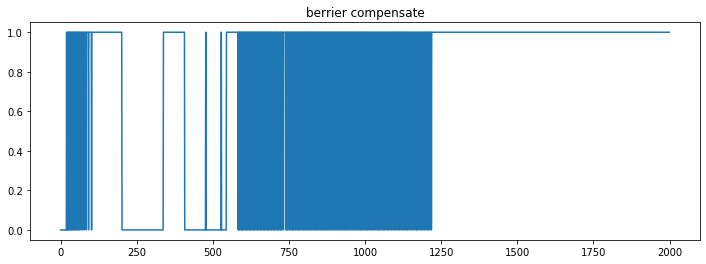

In [22]:
# first episode log
episode_step = int(200 * 0.05 / dt)
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(episode_step), a.cbf_log[:episode_step,0])
plt.plot(range(episode_step), np.zeros(episode_step,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(episode_step), a.cbf_log[:episode_step,1])
plt.show()

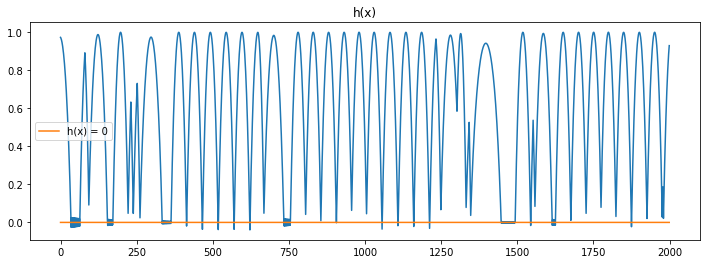

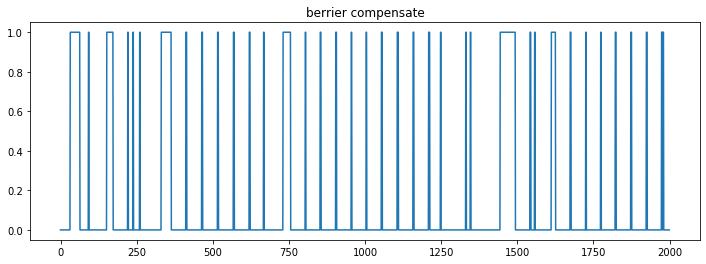

In [25]:
# log per episode
interval = 51
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(episode_step), a.cbf_log[episode_step * interval : episode_step * (interval+1), 0])
plt.plot(range(episode_step), np.zeros(episode_step ,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(episode_step), a.cbf_log[episode_step * interval : episode_step * (interval+1),1])
plt.show()

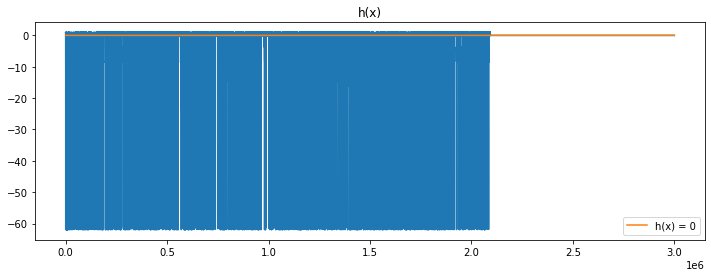

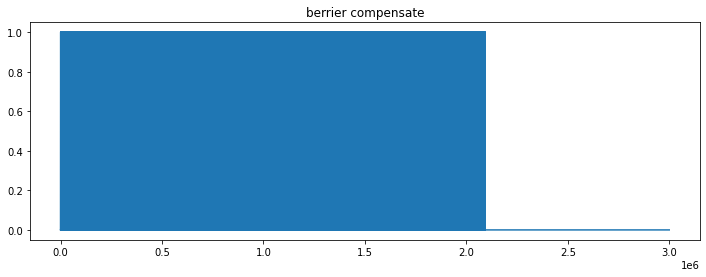

In [6]:
# log throughout learning
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(step), a.cbf_log[:,0])
plt.plot(range(step), np.zeros(step,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(step), a.cbf_log[:,1])
plt.show()

In [10]:
#a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
a.test(env, lam=l, visualize=0, nb_max_episode_steps=episode_step, action_view=0, time_mode=time_mode)

Testing for 1 episodes ...
Episode 1: reward: -187.006, steps: 2000


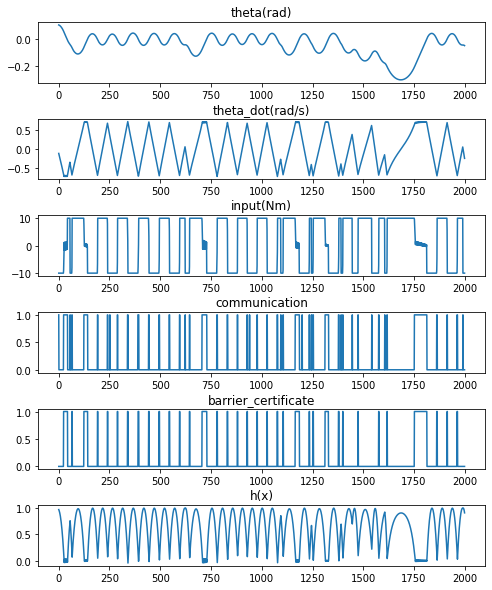

In [11]:
titles = ['theta(rad)', 'theta_dot(rad/s)', 'input(Nm)', 'communication', 'barrier_certificate', 'h(x)'] 
history = a.data_log[0]
x_axis = range(episode_step)
plt.figure(figsize=(8,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(6):
    data = history[:,i]
    plt.subplot(6,1,i+1)
    plt.title(titles[i])
    plt.plot(x_axis, data)
plt.show()

In [20]:
a.save_weights('../learned_models_safe/600000_e2000_l05.h5')

(array([ 949.,   11.,    0.,    0.,    4.,   12.,    5.,    3.,    3.,
        1013.]),
 array([-3.14158925e+00, -2.51327466e+00, -1.88496007e+00, -1.25664549e+00,
        -6.28330898e-01, -1.63091561e-05,  6.28298279e-01,  1.25661287e+00,
         1.88492746e+00,  2.51324205e+00,  3.14155663e+00]),
 <a list of 10 Patch objects>)

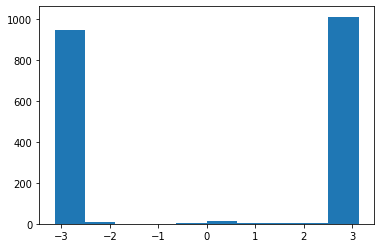

In [11]:
plt.hist(history[:,0])

In [26]:
import csv

with open("../csv/learning_log.csv", "w") as f:
    writer = csv.writer(f)
    for row in a.cbf_log:
        writer.writerow(row)

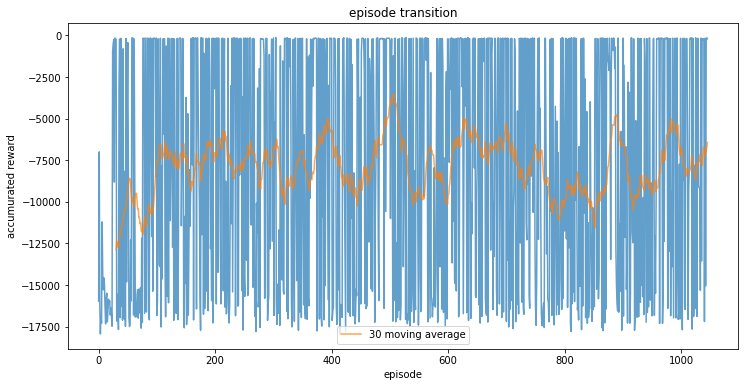

In [13]:
l = 30
plt.figure(figsize=(12,6))
ma = moving_average(a.episode_rewards, l)
plt.plot(range(len(a.episode_rewards)), a.episode_rewards, alpha=0.7)
plt.plot(range(l, len(a.episode_rewards)), ma, label=f'{l} moving average', alpha=0.7)
plt.xlabel('episode')
plt.ylabel('accumurated reward')
plt.title('episode transition')
plt.legend()
plt.show()

In [18]:
rewards = np.array(a.episode_rewards)
import csv

with open("../csv/episode_rewards.csv", "w") as f:
    writer = csv.writer(f)
    for row in rewards:
        writer.writerow([row])